In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0-rc1


In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import signal
import pickle

In [0]:
import pandas as pd
from pandas_datareader import data

In [0]:
#basket = ['AAPL','ABBV','ABT','ACN','ADBE','AGN','AIG','ALL','AMGN','AMZN','AXP','BA','BAC','BIIB','BK','BKNG','BLK','BMY','C','CAT','CELG','CHTR','CL','CMCSA','COF','COP','COST','CSCO','CVS','CVX','DD','DHR','DIS','DOW','DUK','EMR','EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GOOGL','GS','HD','HON','IBM','INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MET','MMM','MO','MRK','MS','MSFT','NEE','NFLX','NKE','NVDA','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB','SO','SPG','T','TGT','TXN','UNH','UNP','USB','UTX','V','VZ','WBA','WFC','WMT','XOM']
basket = ['AXP','AAPL','BA','CAT','CSCO','CVX','XOM','GS','HD','IBM','INTC','JNJ','KO','JPM','MCD','MMM','MRK','MSFT','NKE','PFE','PG','TRV','UNH','UTX','VZ','V','WBA','WMT','DIS','DOW']
#'EXC','F','FB','FDX','GD','GE','GILD','GM','GOOG','GOOGL','GS','HD','HON','IBM','INTC','JNJ','JPM','KHC','KMI','KO','LLY','LMT','LOW','MA','MCD','MET','MMM','MO','MRK','MS','MSFT','NEE','NFLX','NKE','NVDA','ORCL','OXY','PEP','PFE','PG','PM','PYPL','QCOM','RTN','SBUX','SLB','SO','SPG','T','TGT','TXN','UNH','UNP','USB','UTX','V','VZ','WBA','WFC','WMT','XOM']
#df = pd.DataFrame(columns=['High','Low','Open','Close','Volume','Adj Close','Symbol'])
#df.index.names = ["Date"]
cluster = []
for ticker in basket:
  r = data.DataReader(ticker,'yahoo',start = '2012-09-21')
  r['Symbol'] = ticker
  cluster.append(r)
df = pd.concat(cluster)
df = df.sort_index(ascending=True)
print(df)

                  High         Low        Open  ...       Volume   Adj Close  Symbol
Date                                            ...                                 
2012-09-21   58.580002   57.860001   58.450001  ...    6982700.0   52.298706     AXP
2012-09-21   70.150002   69.470001   70.089996  ...   13161000.0   58.512760      BA
2012-09-21   75.089996   74.330002   74.959999  ...   10562300.0   62.488678     WMT
2012-09-21   93.419998   91.370003   93.419998  ...   10786300.0   73.092186     CAT
2012-09-21   35.630001   35.110001   35.630001  ...    8011500.0   29.963469     WBA
2012-09-21   19.200001   18.889999   19.150000  ...   42198200.0   15.195784    CSCO
2012-09-21   33.987499   33.724998   33.825001  ...   29225600.0   30.196123       V
2012-09-21  118.529999  117.470001  118.529999  ...   10280700.0   89.858482     CVX
2012-09-21   45.919998   45.520000   45.720001  ...   21997500.0   33.319275      VZ
2012-09-21   92.230003   91.639999   92.029999  ...   19599100.0 

In [0]:
X_scalers = {}
y_scalers = {}

for stock in basket:
    for col in ('Adj Close', 'High', 'Low', 'Open', 'Volume','Close'):
        df[col] = df[col].astype(float)
        df.loc[df['Symbol'] == stock, col] = signal.detrend(df[df['Symbol'] == stock][col])
    df.loc[df['Symbol'] == stock, 'mean_close_price_2'] = df.loc[df['Symbol'] == stock, 'Adj Close'].rolling(window=2).mean()
    df.loc[df['Symbol'] == stock, 'mean_close_price_3'] = df.loc[df['Symbol'] == stock, 'Adj Close'].rolling(window=3).mean()
    df.loc[df['Symbol'] == stock, 'std_close_price_2'] = df.loc[df['Symbol'] == stock, 'Adj Close'].rolling(window=2).std()
    df.loc[df['Symbol'] == stock, 'std_close_price_3'] = df.loc[df['Symbol'] == stock, 'Adj Close'].rolling(window=3).std()

In [0]:
X_scalers = {stock:{} for stock in basket}
y_scalers = {}

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


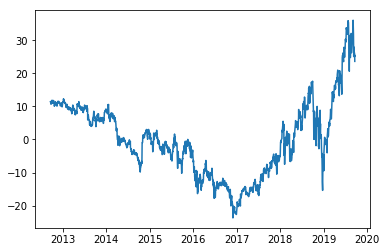

In [0]:
plt.plot(df[df['Symbol'] =='V']['Adj Close'])

In [0]:
df['Tomo_gain'] = df['Adj Close'].shift(-1) - df['Adj Close']
df['Yday_gain'] = df['Tomo_gain'].shift(1)

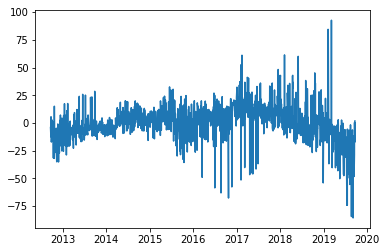

In [0]:
plt.plot(df[df['Symbol'] == 'V']['Tomo_gain'])

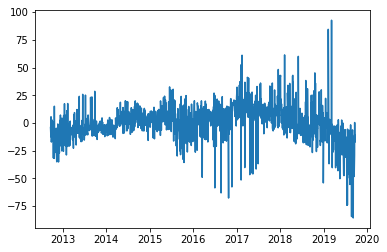

In [0]:
plt.plot(df[df['Symbol'] == 'V'][:-1]['Tomo_gain'])

In [0]:
for stock in basket:
    df = df.drop(df.index[len(df[df['Symbol'] == stock]) - 1], axis=0)
    outliers = abs(df[df['Symbol'] == stock]['Tomo_gain']) < df[df['Symbol'] == stock]['Tomo_gain'].std() * 3
    df[df['Symbol'] == stock] = df[df['Symbol'] == stock].loc[:, :][outliers]
    df = df.drop(df[df['Symbol'] == stock].iloc[-1].name) # get rid of last because next is a different stock
    pre_y = df[df['Symbol'] == stock]['Tomo_gain'].values
    y_scalers[stock] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
    for col in ('Adj Close', 'High', 'Low', 'Open', 'Volume', 'mean_close_price_2', 'Close',\
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'Yday_gain'):
        pre_x = df[df['Symbol'] == stock][col]
        X_scalers[stock][col] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
        df.loc[df['Symbol'] == stock, col] = X_scalers[stock][col].fit_transform(pre_x.values.reshape(-1,1))
    df.loc[df['Symbol'] == stock, 'Tomo_gain'] = y_scalers[stock].fit_transform(pre_y.reshape(-1, 1)).reshape(-1)

In [0]:
pickle.dump(X_scalers, open('x_scalers.pkl', 'wb'))
pickle.dump(y_scalers, open('y_scalers.pkl', 'wb'))

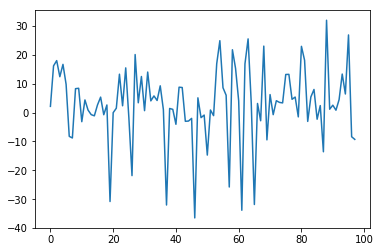

In [0]:
plt.plot(pre_y)

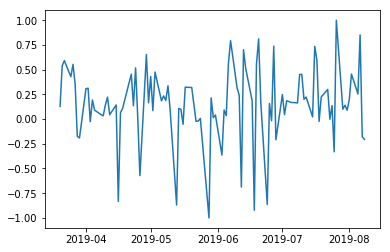

In [0]:
plt.plot( df.loc[df['Symbol'] == basket[-1], 'Tomo_gain'])

In [0]:
df = df.dropna(axis=0)

In [0]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,Symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,Tomo_gain,Yday_gain
Date,,,,,,,,,,,,,
2012-09-25,-0.457225,-0.455753,-0.431744,-0.482351,-0.546930,-0.349302,UTX,-0.340080,-0.326026,-0.691133,-0.681717,0.484286,-0.518375
2012-09-25,0.547395,0.545188,0.530999,0.511619,-0.838853,0.517816,IBM,0.524411,0.529474,-0.966127,-0.913422,-0.335003,0.322908
2012-09-25,-0.278158,-0.232295,-0.250197,-0.250270,-0.870735,-0.206499,PG,-0.198754,-0.198679,-0.954689,-0.937562,0.031393,-0.166062
2012-09-25,-0.139244,-0.106054,-0.136681,-0.208259,-0.666656,-0.117732,KO,-0.085734,-0.088643,-0.823430,-0.843632,-0.257265,0.205672
2012-09-25,-0.699757,-0.640480,-0.618230,-0.632208,-0.793039,-0.584475,DIS,-0.639806,-0.677239,-0.942806,-0.955727,0.212081,-0.078390


In [0]:
df[df['Symbol'] == 'V'].describe()


,High,Low,Open,Close,Volume,Adj Close,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,Tomo_gain,Yday_gain
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,-0.214169,-0.235297,-0.224588,-0.220302,-0.797233,-0.227187,-0.228638,-0.232304,-0.818484,-0.758082,0.019401,-0.127181
std,0.360319,0.351667,0.351756,0.354897,0.118398,0.353495,0.353533,0.359500,0.210975,0.242185,0.290247,0.208435
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.496462,-0.506332,-0.500604,-0.498397,-0.857792,-0.502425,-0.505111,-0.515843,-0.948060,-0.908503,-0.161350,-0.235398
50%,-0.220983,-0.243086,-0.234574,-0.227457,-0.816526,-0.232616,-0.235450,-0.237298,-0.882261,-0.827884,0.012656,-0.123482
75%,0.063360,0.033051,0.045825,0.054233,-0.762411,0.038112,0.033321,0.037726,-0.763784,-0.704899,0.186405,-0.014484
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
df.shape

(48593, 13)

In [0]:
num_df_cols = df.shape[1] - 1 + len(basket) -1
print(num_df_cols)

41


In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_df_cols, input_shape=(1, num_df_cols)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1)) # dont squash output gradient

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [0]:
X = df.drop(['Tomo_gain', 'Symbol'], axis=1)
y = df['Tomo_gain']

In [0]:
dummies = pd.get_dummies(df['Symbol'], columns=['Symbol'])

In [0]:
X = np.append(X, dummies.values, axis=1)

In [0]:
X.shape

(48593, 41)

In [0]:
X = np.reshape(X, (-1, 1, num_df_cols))

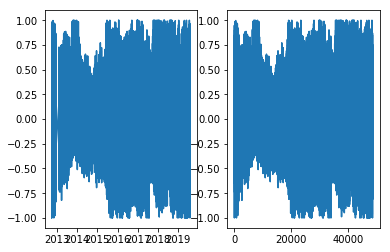

In [0]:
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.plot(df['Tomo_gain'].values)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
model.fit(X_train, y_train.values.reshape(-1,1), batch_size=64, epochs=200, verbose=10)
model.fit(X_train, y_train.values.reshape(-1,1), batch_size=32, epochs=6)

Train on 38874 samples
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/20

In [0]:
y_test = np.asarray(y_test)
print(type(y_test))
model.evaluate(X_test, y_test)


<class 'numpy.ndarray'>
9719/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.05931060657626545, 0.059310596]

In [0]:
model.reset_states()

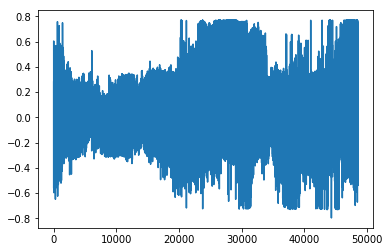

In [0]:
plt.plot(model.predict(X))

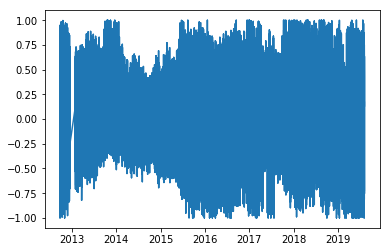

In [0]:
plt.plot(y)

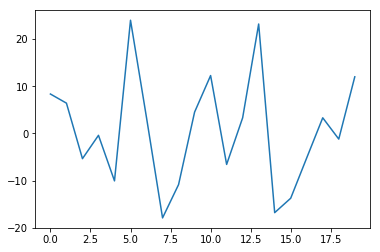

In [0]:
plt.plot(y_scalers['V'].inverse_transform(model.predict(X[100:120])))

In [0]:
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

In [0]:
pad_stock('AAPL')

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
model.save('shellHackModel.h5')

In [0]:
model.layers

In [0]:
model.pop()
model.pop()

In [0]:
model.layers[0].trainable = False
model.layers[3].trainable = False

In [0]:
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

In [0]:
basket_dfs = {}
specific_models = {}
for stock in basket:
    basket_dfs[stock] = df[df['Symbol'] == stock]
    specific_models[stock] = tf.keras.models.clone_model(model)
    specific_models[stock].set_weights(model.get_weights())

In [0]:
specific_models['V'].layers

In [0]:
for stock in basket:
    specific_models[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [0]:
Xes = {}
ys = {}
for stock in basket:
    repeated_dummies = pad_stock(stock).reshape(1,-1).repeat(len(basket_dfs[stock]),axis=0)
    Xes[stock] = np.append(basket_dfs[stock].drop(['Tomo_gain', 'Symbol'], axis=1).values, repeated_dummies, axis=1)
    Xes[stock] = np.reshape(Xes[stock], (-1, 1, num_df_cols))
    ys[stock] = basket_dfs[stock]['Tomo_gain'].values.reshape(-1,1)

In [0]:
Xes_train, ys_train, Xes_test, ys_test, best_model_scores, best_model = {}, {}, {}, {}, {}, {}

In [0]:
for stock in basket:
    best_model_scores[stock] = 1e6
for stock in basket:
    Xes_train[stock] = Xes[stock][:-5]
    ys_train[stock] = ys[stock][:-5]
    Xes_test[stock] = Xes[stock][-5:]
    ys_test[stock] = ys[stock][-5:]
    for i in range(8):
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=64, epochs=70, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=16, epochs=30, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=1, epochs=1, verbose=0)
        evaluation = specific_models[stock].evaluate(Xes_test[stock], ys_test[stock])[0]
        if evaluation < best_model_scores[stock]:
            best_model_scores[stock] = evaluation
            print('now saving {} because it was the best with eval score {}'.format(stock, evaluation))
            best_model[stock] = tf.keras.models.clone_model(specific_models[stock])
            best_model[stock].set_weights(specific_models[stock].get_weights())
            best_model[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        else:
            print('did not save {} because it did not improve with eval score {}'.format(stock, evaluation))

5/1 [======================================================================================================================================================] - 0s 85ms/sample - loss: 0.1185 - mse: 0.1185
now saving AXP because it was the best with eval score 0.11849864572286606
5/1 [======================================================================================================================================================] - 0s 640us/sample - loss: 0.1261 - mse: 0.1261
did not save AXP because it did not improve with eval score 0.1261357218027115
5/1 [======================================================================================================================================================] - 0s 635us/sample - loss: 0.1494 - mse: 0.1494
did not save AXP because it did not improve with eval score 0.14937815070152283
5/1 [======================================================================================================================================================

In [0]:
for stock in basket:
  specific_models[stock] = best_model[stock]

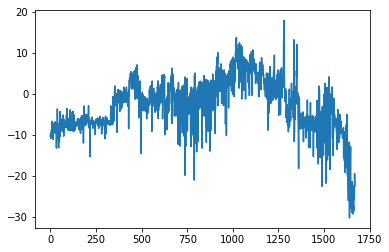

In [0]:
plt.plot(y_scalers['V'].inverse_transform(specific_models['V'].predict(Xes['V'])))


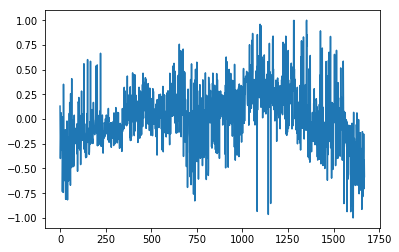

In [0]:
plt.plot(ys['V'])

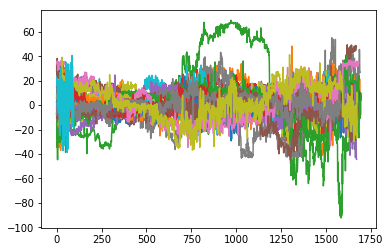

In [0]:
for stock in basket:
    plt.plot(y_scalers[stock].inverse_transform(specific_models[stock].predict(Xes[stock])))

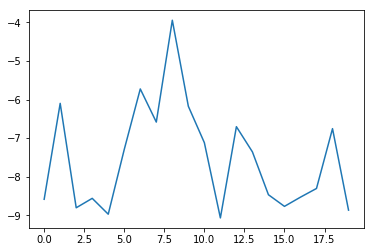

In [0]:
plt.plot(y_scalers['V'].inverse_transform(specific_models['V'].predict(Xes['V'][100:120])))

In [0]:
for stock in basket:
    today = df[df['Symbol'] == stock].iloc[-1].drop(['Tomo_gain', 'Symbol'])
    today = np.append(today, pad_stock(stock))
    today = np.array(today,np.float32)
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(np.reshape(today, (-1, 1, num_df_cols)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asscalar(pred)))

Stock AXP, pred: -12.201254844665527
Stock AAPL, pred: 1.4158918857574463
Stock BA, pred: 4.388688087463379
Stock CAT, pred: 9.336181640625
Stock CSCO, pred: -6.1686201095581055
Stock CVX, pred: 1.1420304775238037
Stock XOM, pred: -7.675885200500488
Stock GS, pred: 26.800796508789062
Stock HD, pred: -14.700068473815918
Stock IBM, pred: -2.3096587657928467
Stock INTC, pred: 3.624906301498413
Stock JNJ, pred: 15.61325454711914
Stock KO, pred: 2.8949499130249023
Stock JPM, pred: 0.35773637890815735
Stock MCD, pred: -44.372066497802734
Stock MMM, pred: 47.73246383666992
Stock MRK, pred: -2.3186452388763428
Stock MSFT, pred: -9.723082542419434
Stock NKE, pred: -11.583930969238281
Stock PFE, pred: 2.3149871826171875
Stock PG, pred: 0.3091227114200592
Stock TRV, pred: 7.121326923370361
Stock UNH, pred: 20.71179962158203
Stock UTX, pred: -1.0200163125991821
Stock VZ, pred: -0.09230083972215652
Stock V, pred: -22.536800384521484
Stock WBA, pred: 34.82382583618164
Stock WMT, pred: -7.71543502807

In [0]:
for stock, model in specific_models.items():
    model.save('finetuned_{}.h5'.format(stock))